In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_theme("notebook", style = 'whitegrid', rc = {'axes.grid' : False,
                                                    'figure.figsize':(11.7,8.27)})

### Abrindo os dados

In [3]:
def get_dados_SEPEP(file_name = 'Base de dados 20210526 - 17h03min.xlsx', sheet_name = 'Sugestão'):
    
    path_dados = '../Dados_originais/Base_Dados_Sepep/'
    
    f_path = os.path.join(path_dados, file_name)
    sugestoes = pd.read_excel(f_path, sheet_name = sheet_name)
    
    return sugestoes

In [4]:
def get_dados_SF(file_name = 'Base de Propostas recebidas PLOA2022.xlsx'):
    
    path_dados = '../Dados_originais/PLOA/'
    
    f_path = os.path.join(path_dados, file_name)
    contribuicoes = pd.read_excel(f_path,
                                  sheet_name = 'projeto-de-lei-orcamentaria-anu')
    
    return contribuicoes

In [5]:
dados_sf = get_dados_SF()

In [6]:
dados_sepep = get_dados_SEPEP()

C:\Users\h-pgy\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [7]:
def drop_empty_cols(df):
    
    df = df.copy()
    cols_empty = [col for col, val in 
                  df.isnull().all().to_dict().items() 
                  if val]
    print(cols_empty)
    
    df.drop(cols_empty, axis = 1, inplace=True)
    
    return df

In [8]:
dados_sf = drop_empty_cols(dados_sf)

[]


In [9]:
dados_sepep = drop_empty_cols(dados_sepep)

['Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']


In [10]:
dados_sepep.isnull().apply(all, axis = 1).sum()

0

In [11]:
dados_sf.isnull().apply(all, axis = 1).sum()

0

#### Criar coluna categorias nos dados da SEPEP

In [12]:
de_para_sec_cat = {
    'CET' : 'Transportes e Mobilidade',
    'CGM' : 'Outros temas',
    'SECOM' : 'Outros temas',
    'SEHAB' : 'Habitação',
    'SEME' : 'Esporte e Lazer',
    'SF' : 'Outros temas',
    'SGM' : 'Outros temas',
    'SIURB' : 'Infraestrutura Urbana e Obras',
    'SMADS' : 'Assistência Social',
    'SMC' : 'Cultura',
    'SMDET' : 'Desenvolvimento Econômico e Trabalho',
    'SMDHC' : 'Direitos Humanos e Cidadania',
    'SME' : 'Educação',
    'SMIT' : 'Inovação e Tecnologia',
    'SMPED' : 'Pessoa com Deficiência',
    'SMRI' : 'Outros temas',
    'SMS' : 'Saúde',
    'SMSU' : 'Segurança Urbana',
    'SMSUB' : 'Zeladoria Urbana e melhorias de bairro',
    'SMT' : 'Transportes e Mobilidade',
    'SMUL' : 'Urbanismo e Licenciamento',
    'SP-Obras' : 'Infraestrutura Urbana e Obras',
    'SVMA' : 'Meio Ambiente'
}

In [13]:
dados_sepep['Categoria'] = dados_sepep['Sec Ajustado'].apply(lambda x: de_para_sec_cat.get(x, 'Outros temas'))

In [14]:
dados_sepep[dados_sepep['Categoria']=='Null']

,Contribuição ID,Sugestão,Cod Sugestão,Sub Origem,Sub Conteúdo,Sub Final,Sugestão.1,Apoio P+,Secretaria,Tema,S-T,Sec Ajustado,Tema Ajustado,Categoria


#### Pegando canal pelo ID

aqui vamos identificar o id do canal de participação.

In [15]:
def aux_contribuicao_id(item):
    
    if pd.isnull(item):
        return 'Não identificado'
    if str(item).startswith('C'):
        return int(item.split('.')[0].replace('C', ''))
    #se nao começa com C e não é nulo então é P+
    else:
        return 37

In [16]:
dados_sepep['id_audiencia'] = dados_sepep['Contribuição ID'].apply(aux_contribuicao_id)

In [17]:
#one-liner monstro e meio exagerado hehe
de_para_canais = get_dados_SEPEP(sheet_name = 'ID e lista suspensa')[['Municipe', 'Unnamed: 1']].drop(0).rename(
                    {'Municipe' : 'id', 'Unnamed: 1' : 'Canal'}, axis =1).replace('\xa0', np.NaN).dropna().set_index('id')['Canal'].to_dict()

In [18]:
dados_sepep['canal'] = dados_sepep['id_audiencia'].apply(lambda x: de_para_canais[x])

In [19]:
dados_sepep['canal'].unique()

array(['Santana', 'Itaim Paulista', 'Jabaquara', 'Freguesia', 'Pinheiros',
       'Casa Verde', 'Jaçanã', 'Mooca', 'Documento', 'Sé', 'Santo Amaro',
       'Itaquera', 'Penha', 'Capela do Socorro', 'Pirituba/Jaraguá',
       'Guaianases', 'Lapa', 'Parelheiros', 'São Miguel', "M'Boi Mirim",
       'Perus', 'Temática 2 (SP Ágil  + SP  Segura e Bem Cuidada)',
       'Campo Limpo', 'V Maria V Guilherme', 'Sapopemba', 'Ipiranga',
       'Aricanduva',
       'Temática 3 (SP Eficiente + SP Global e Sustentável + SP Inovadora e Criativa)',
       'São Mateus', 'Butantã', 'Vila Mariana', 'Geral', 'Cidade Ademar',
       'Cidade Tiradentes', 'Temática 1 (SP Justa e Inclusiva)',
       'Vila Prudente', 'Participe+'], dtype=object)

### Arrumando subprefeitura

Aqui vamos colocar "suprarregional" quando for um canal de participação suprarregional (audiencias temáticas ou geral)

In [20]:
def aux_supraregional(row):
    
    canais_supra = [
        'Temática 3 (SP Eficiente + SP Global e Sustentável + SP Inovadora e Criativa)',
        'Temática 2 (SP Ágil  + SP  Segura e Bem Cuidada)',
        'Temática 1 (SP Justa e Inclusiva)',
        'Participe+',
        'Documento',
        'Geral'
    ]
    
    if pd.isnull(row['Sub Final']):
        
        if row['canal'] in canais_supra:
            return "SUPRARREGIONAL"
        else:
            print(row)
            return "SUPRARREGIONAL"
    else:
        return row['Sub Final']

In [21]:
dados_sepep['subs_final_supra'] = dados_sepep.apply(lambda row: aux_supraregional(row), axis = 1)

Contribuição ID                                                C29.9
Sugestão                                                         5.0
Cod Sugestão                                                 C29.9.5
Sub Origem                                                       NaN
Sub Conteúdo                                                     NaN
Sub Final                                                        NaN
Sugestão.1         Trabalhando com os programas das escolas para ...
Apoio P+                                                         NaN
Secretaria                                                     SMDET
 Tema                                     Capacitação empreendedores
S-T                                 SMDET-Capacitação empreendedores
Sec Ajustado                                                   SMDET
Tema Ajustado                                  Cursos e capacitações
Categoria                       Desenvolvimento Econômico e Trabalho
id_audiencia                      

### Padronizando Subs

In [22]:
subs = gpd.read_file('mapas_geosampa/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp')

In [23]:
#especificar a projeção SIRGAS
subs.crs = {'init': 'EPSG:4674'}


In [24]:
#arrumar o tipo de uma coluna que veio errado
subs['sp_id'] = subs['sp_id'].apply(int)

In [25]:
#note que ainda tem alguma sujeira no campo de subprefeituras, vamos arrumar
dados_sepep['subs_final_supra'].value_counts()

SUPRARREGIONAL         685
Pinheiros              212
Perus                  208
Sé                     155
Lapa                   147
Pirituba/Jaraguá       145
Butantã                144
Capela do Socorro      139
Cidade Tiradentes      121
São Mateus             119
Mooca                  110
Santo Amaro            109
Itaim Paulista         108
Freguesia              102
Guaianases             100
M'Boi Mirim             99
Sapopemba               96
Cidade Ademar           96
São Miguel              96
Jabaquara               94
Parelheiros             94
Vila Mariana            87
Itaquera                83
Penha                   82
V Maria V Guilherme     76
Jaçanã                  75
Ermelino Matarazzo      70
V Maria/V Guilherme     70
Vila Prudente           67
Campo Limpo             61
Temática 3              56
Santana                 51
Casa Verde              50
Aricanduva              46
Ipiranga                25
has                      1
Name: subs_final_supra, dtyp

In [26]:
dados_sepep[dados_sepep['subs_final_supra']=='has ']

,Contribuição ID,Sugestão,Cod Sugestão,Sub Origem,Sub Conteúdo,Sub Final,Sugestão.1,Apoio P+,Secretaria,Tema,S-T,Sec Ajustado,Tema Ajustado,Categoria,id_audiencia,canal,subs_final_supra
3162,156,NaN,NaN,has,NaN,has,SAÚDE DA POPULAÇÃO NEGRA. Efetivar o PROGRAMA...,39.0,SMS,Saúde população negra,SMS-Saúde população negra,SMS,Saúde população negra,Saúde,37,Participe+,has


In [27]:
de_para_subs_sepep = { 
        'Aricanduva' : 'ARICANDUVA-FORMOSA-CARRAO',
        'Butantã' : 'BUTANTA',
        'Campo Limpo' : 'CAMPO LIMPO',
        'Capela do Socorro' : 'CAPELA DO SOCORRO',
        'Casa Verde' : 'CASA VERDE-CACHOEIRINHA',
        'Cidade Ademar' : 'CIDADE ADEMAR',
        'Cidade Tiradentes' : 'CIDADE TIRADENTES',
        'Ermelino Matarazzo' : 'ERMELINO MATARAZZO',
        'Freguesia' : 'FREGUESIA-BRASILANDIA',
        'Guaianases' : 'GUAIANASES',
        'Ipiranga' : 'IPIRANGA',
        'Itaim Paulista' : 'ITAIM PAULISTA',
        'Itaquera' : 'ITAQUERA',
        'Jabaquara' : 'JABAQUARA',
        'Jaçanã' : 'JACANA-TREMEMBE',
        'Jaçanã/ Tremenbé ' : 'JACANA-TREMEMBE',
        'Lapa' : 'LAPA',
        "M'Boi Mirim" : "M'BOI MIRIM",
        'Mooca' : 'MOOCA',
        'Parelheiros' : 'PARELHEIROS', 
        'Penha' : 'PENHA',
        'Perus' : 'PERUS',
        'Pinheiros' : 'PINHEIROS',
        'Pirituba/Jaraguá' : 'PIRITUBA-JARAGUA',
        'Santana' : 'SANTANA-TUCURUVI',
        'Santo Amaro' : 'SANTO AMARO',
        'São Mateus' : 'SAO MATEUS',
        'São Miguel' : 'SAO MIGUEL',
        'Sapopemba' : 'SAPOPEMBA',
        'Sé' : 'SE',
        'V Maria/V Guilherme' : 'VILA MARIA-VILA GUILHERME',
        'V Maria V Guilherme' : 'VILA MARIA-VILA GUILHERME',
        'Vila Mariana' : 'VILA MARIANA',
        'Vila Prudente' : 'VILA PRUDENTE',
        'Temática 3' : 'SUPRARREGIONAL',
        'Temática 2' : 'SUPRARREGIONAL',
        'Temática 1' : 'SUPRARREGIONAL',
        'Geral' : 'SUPRARREGIONAL',
        'SUPRARREGIONAL' : 'SUPRARREGIONAL',
        'has ' : 'SUPRARREGIONAL',
        'NÃO IDENTIFICADO' : 'NÃO IDENTIFICADO'

    }

In [28]:
#aqui é para dar key error mesmo caso apareça termo novo
dados_sepep['subs_padrao'] = dados_sepep['subs_final_supra'].apply(lambda x: de_para_subs_sepep[x])

In [29]:
de_para_subs_sf = {
    'Aricanduva/Formosa/Carrão' : 'ARICANDUVA-FORMOSA-CARRAO',
    'Butantã' : 'BUTANTA',
    'Campo Limpo' : 'CAMPO LIMPO',
    'Capela do Socorro' : 'CAPELA DO SOCORRO',
    'Casa Verde' : 'CASA VERDE-CACHOEIRINHA',
    'Cidade Ademar' : 'CIDADE ADEMAR',
    'Cidade Tiradentes' : 'CIDADE TIRADENTES',
    'Ermelino Matarazzo' : 'ERMELINO MATARAZZO',
    'Freguesia/Brasilândia' : 'FREGUESIA-BRASILANDIA',
    'Guaianases' : 'GUAIANASES',
    'Ipiranga' : 'IPIRANGA',
    'Itaim Paulista' : 'ITAIM PAULISTA',
    'Itaquera' : 'ITAQUERA',
    'Jabaquara' : 'JABAQUARA',
    'Jaçanã/Tremembé' : 'JACANA-TREMEMBE',
    'Lapa' : 'LAPA',
    "M'Boi Mirim" : "M'BOI MIRIM",
    'Mooca' : 'MOOCA',
    'Parelheiros' : 'PARELHEIROS', 
    'Penha' : 'PENHA',
    'Perus' : 'PERUS',
    'Pinheiros' : 'PINHEIROS',
    'Pirituba/Jaraguá' : 'PIRITUBA-JARAGUA',
    'Santana/Tucuruvi' : 'SANTANA-TUCURUVI',
    'Santo Amaro' : 'SANTO AMARO',
    'Sapopemba' : 'SAPOPEMBA',
    'São Mateus' : 'SAO MATEUS',
    'São Miguel' : 'SAO MIGUEL',
    'Sé' : 'SE',
    'Vila Maria/Vila Guilherme' : 'VILA MARIA-VILA GUILHERME',
    'Vila Mariana' : 'VILA MARIANA',
    'Vila Prudente' : 'VILA PRUDENTE'
    }

In [30]:
dados_sf['subs_padrao'] = dados_sf['Subprefeitura'].apply(lambda x: de_para_subs_sf[x])

In [31]:
dados_sf['count'] = 1
dados_sepep['count']=1

In [32]:
def qtd_registros_por_subs(df):
    
    qtd_reg_subs = df.groupby('subs_padrao').count()\
                ['count'].to_dict()
    
    return qtd_reg_subs

In [33]:
def add_qtd_reg_col(df_subs, new_col, qtd_reg_dict):
    
    df_subs = df_subs.copy()
    
    df_subs[new_col] = df_subs['sp_nome'].apply(lambda x: qtd_reg_dict.get(x, 0))
    
    return df_subs

In [34]:
qtd_por_subs_sepep = qtd_registros_por_subs(dados_sepep)

In [35]:
qtd_por_subs_sf = qtd_registros_por_subs(dados_sf)

In [36]:
subs = add_qtd_reg_col(subs, 'qtd_por_subs_sepep', qtd_por_subs_sepep)

In [37]:
subs = add_qtd_reg_col(subs, 'qtd_por_subs_sf', qtd_por_subs_sf)

In [38]:
subs.sample(3)

,sp_codigo,sp_nome,sp_id,geometry,qtd_por_subs_sepep,qtd_por_subs_sf
5,22,ERMELINO MATARAZZO,8,"POLYGON ((349086.305 7399600.645, 349096.094 7...",70,56
1,03,FREGUESIA-BRASILANDIA,2,"POLYGON ((327469.803 7399113.522, 327449.180 7...",102,52
18,19,CAPELA DO SOCORRO,25,"POLYGON ((324527.553 7376998.577, 324527.430 7...",139,94


### Plotar mapas por subprefeitura

In [39]:
def cmap_plot(geodf, col, title, f_name = None, path='mapas_subprefeituras_final'):
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    ax = geodf.plot(column=col, cmap = 'GnBu',
                legend_kwds={'label': "Quantidade",
                             'orientation': "vertical"},
               legend=True,
               figsize = (10, 15))
    
    plt.axis('off')
    
    fig = ax.get_figure()
    
    if f_name is None:
        f_name = title+'.png'
    
    fig.savefig(os.path.join(path, f_name))

In [40]:
subs['qtd_por_subs_total'] = subs['qtd_por_subs_sepep'] + subs['qtd_por_subs_sf']

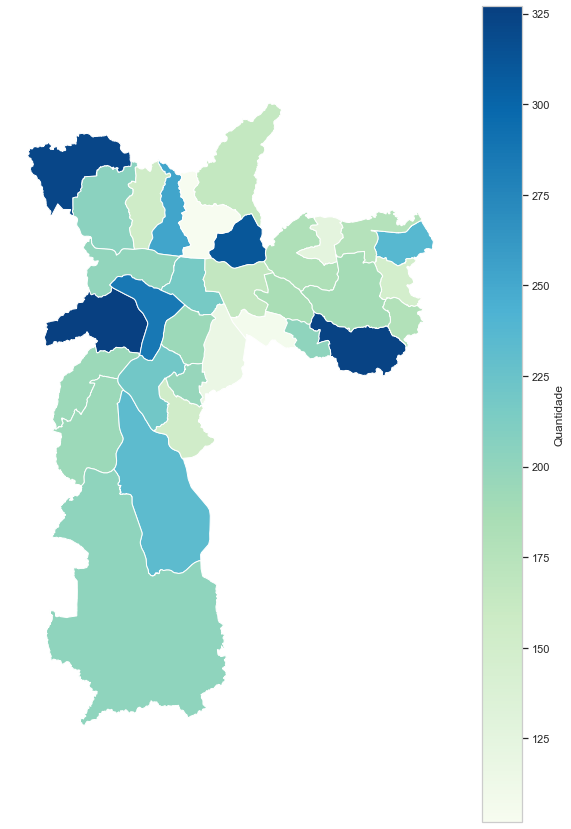

In [41]:
cmap_plot(subs, 'qtd_por_subs_total', 'Quantidade de Sugestões Total por Subprefeitura')

### Plotar graficos

In [42]:
def plot_qtd(data, y):
    
    mapa = sns.countplot(y=y, data=data, color = 'steelblue',
                       order = data[y].value_counts().index)
    return mapa

In [43]:
def salvar_graficos(mapa, titulo_grafico, path ='graficos_final'):
    
    if not os.path.exists(path):
        os.makedirs(path),
    
    f_name = f'{titulo_grafico}.png'
    f_path = os.path.join(path, f_name)
    mapa.figure.savefig(f_path, bbox_inches='tight')
    plt.clf

In [44]:
dados_geral = pd.concat([
    dados_sf[['Categoria', 'subs_padrao']].copy(),
    dados_sepep[['Categoria', 'subs_padrao']].copy()
    ])

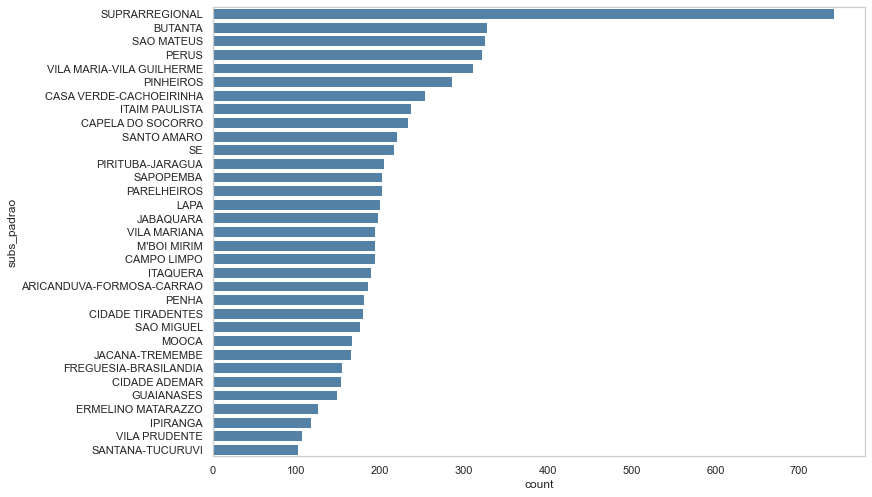

In [45]:
qtd_sugests_por_subs = plot_qtd(dados_geral, 'subs_padrao')

In [46]:
salvar_graficos(qtd_sugests_por_subs, 'Quantidade de Sugestões Geral por Subprefeitura')

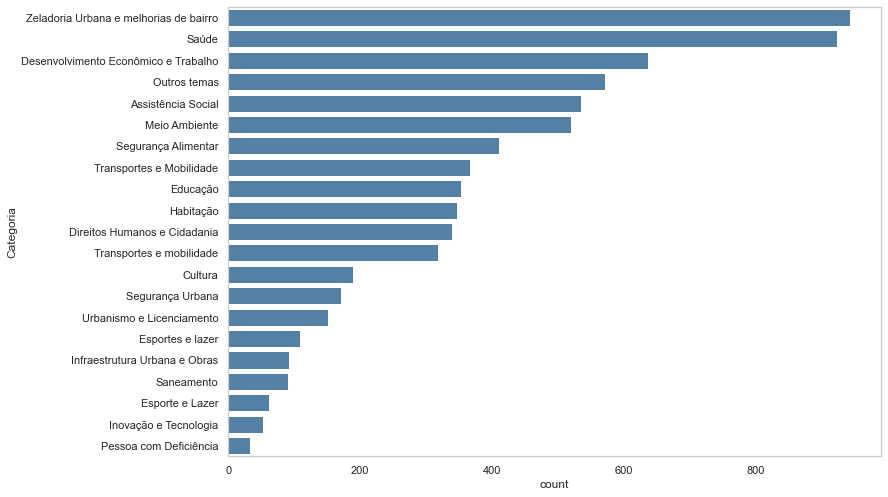

In [47]:
qtd_sugests_por_cat = plot_qtd(dados_geral, 'Categoria')

In [48]:
salvar_graficos(qtd_sugests_por_cat, 'Quantidade de Sugestões Geral por Categoria')

### Dados por canal de entrada SEPEP

In [49]:
dados_sepep['canal'].unique()

array(['Santana', 'Itaim Paulista', 'Jabaquara', 'Freguesia', 'Pinheiros',
       'Casa Verde', 'Jaçanã', 'Mooca', 'Documento', 'Sé', 'Santo Amaro',
       'Itaquera', 'Penha', 'Capela do Socorro', 'Pirituba/Jaraguá',
       'Guaianases', 'Lapa', 'Parelheiros', 'São Miguel', "M'Boi Mirim",
       'Perus', 'Temática 2 (SP Ágil  + SP  Segura e Bem Cuidada)',
       'Campo Limpo', 'V Maria V Guilherme', 'Sapopemba', 'Ipiranga',
       'Aricanduva',
       'Temática 3 (SP Eficiente + SP Global e Sustentável + SP Inovadora e Criativa)',
       'São Mateus', 'Butantã', 'Vila Mariana', 'Geral', 'Cidade Ademar',
       'Cidade Tiradentes', 'Temática 1 (SP Justa e Inclusiva)',
       'Vila Prudente', 'Participe+'], dtype=object)

In [50]:
def aux_canal(canal):
    
    if canal == 'Geral':
                return "Audiência Pública Geral"
    elif canal.startswith('Temática'):
        return "Audiências Temáticas"
    elif canal == 'Participe+':
        return "Portal Participe+"
    elif canal == 'Documento':
        return "Ofícios e outros docs."
    else:
        return 'Audiênca Pública Regional'


In [51]:
dados_sepep['canal_agrupado'] = dados_sepep['canal'].apply(aux_canal)

In [52]:
dados_sepep['canal_agrupado'].value_counts()

Audiênca Pública Regional    2303
Portal Participe+            1072
Audiências Temáticas          358
Ofícios e outros docs.        255
Audiência Pública Geral        91
Name: canal_agrupado, dtype: int64

In [53]:
contribuicoes = get_dados_SEPEP(sheet_name='Contribuição Integral')

C:\Users\h-pgy\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [54]:
contribuicoes = drop_empty_cols(contribuicoes)

['Unnamed: 5']


In [55]:
contribuicoes.isnull().apply(all, axis = 1).sum()

0

In [56]:
contribuicoes.head()

,Municipe ID,Contribuição ID,Sub Origem,Contribuição (revisada),Apoio P+
0,1.10,1.10,NaN,"Boa tarde a todas e todos, meu nome é Francisc...",NaN
1,1.10,1.10,NaN,"Oi Sou Mário Sérgio Bortolotto, por favor você...",NaN
2,1.11,1.11,NaN,Então boa tarde a todos e todas. Eu comprimen...,NaN
3,1.12,1.12,NaN,"Muito obrigada agradeço a oportunidade, eu tam...",NaN
4,1.13,1.13,NaN,"Bom dia a todos, meu nome é Maria Luiza Kovals...",NaN


In [57]:
def aux_id_cointribuicao(item):
    
    if pd.isnull(item):
        return None
    else:
        item = str(item)
        if item.startswith('37'):
            return 37
        else:
            return int(item.split('.')[0])

In [58]:
contribuicoes['id_canal'] = contribuicoes['Contribuição ID'].apply(aux_id_cointribuicao)

In [59]:
contribuicoes['id_canal'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 38,  4,  5,  6,
        7,  8,  9, 37], dtype=int64)

In [60]:
contribuicoes['canal'] = contribuicoes['id_canal'].apply(lambda x: de_para_canais[x])

In [61]:
contribuicoes['canal_agrupado'] = contribuicoes['canal'].apply(aux_canal)

In [62]:
contribuicoes['canal_agrupado'].value_counts()

Portal Participe+            864
Audiênca Pública Regional    551
Audiências Temáticas          77
Audiência Pública Geral       23
Ofícios e outros docs.         9
Name: canal_agrupado, dtype: int64

In [63]:
contrib_audi_regionais = contribuicoes[contribuicoes['canal_agrupado']=='Audiênca Pública Regional'].copy()

In [64]:
contrib_audi_regionais[contrib_audi_regionais['Sub Origem'].isnull()]

,Municipe ID,Contribuição ID,Sub Origem,Contribuição (revisada),Apoio P+,id_canal,canal,canal_agrupado
412,31.10,31.10,NaN,"Boa noite a todos os presentes. Boa noite, vi...",NaN,31,Vila Prudente,Audiênca Pública Regional
413,31.10,31.10,NaN,"Boa noite, obrigado. Eu também tive dificuldad...",NaN,31,Vila Prudente,Audiênca Pública Regional
414,31.11,31.11,NaN,Boa noite. Primeiramente agradecer a oportunid...,NaN,31,Vila Prudente,Audiênca Pública Regional
415,31.12,31.12,NaN,"Olá pessoal, boa noite a todos. Minha satisfaç...",NaN,31,Vila Prudente,Audiênca Pública Regional
416,31.13,31.13,NaN,"Boa noite a todos, eu quero agradecer o convit...",NaN,31,Vila Prudente,Audiênca Pública Regional
417,31.14,31.14,NaN,Boa noite a todos. Agradeço a oportunidade tam...,NaN,31,Vila Prudente,Audiênca Pública Regional
418,31.15,31.15,NaN,Boa noite a todos e todas. Estão me ouvindo? E...,NaN,31,Vila Prudente,Audiênca Pública Regional
419,31.16,31.16,NaN,"Boa noite a todos, boa noite a todas. Quero me...",NaN,31,Vila Prudente,Audiênca Pública Regional
420,31.17,31.17,NaN,Eu já quero começar a reunião fazendo um desab...,NaN,31,Vila Prudente,Audiênca Pública Regional
421,31.18,31.18,NaN,Boa noite. Então eu sou o Manoel dos Santos de...,NaN,31,Vila Prudente,Audiênca Pública Regional


In [65]:
def arrumar_sub_audiencias(row):
    
    if pd.isnull(row['Sub Origem']):
        
        return row['canal']
    else:
        return row['Sub Origem']

In [66]:
contrib_audi_regionais['sub_arrumado'] = contrib_audi_regionais.apply(
        lambda row: arrumar_sub_audiencias(row), axis =1)

In [67]:
contrib_audi_regionais['subs_padrao'] = contrib_audi_regionais['sub_arrumado'].apply(lambda x: de_para_subs_sepep[x])

In [68]:
contrib_audi_regionais['count'] = 1

In [69]:
sugest_audi_regionais = dados_sepep[dados_sepep['canal_agrupado']=='Audiênca Pública Regional'].copy()

In [70]:
falas_audi_regionais = len(contrib_audi_regionais)
sugestoes_audi_regionais = len(sugest_audi_regionais)
media_sugest_fala = round(sugestoes_audi_regionais/falas_audi_regionais, 0)

In [71]:
print(f'''
O total de falas nas Audiências Públicas Regionais do Programa de Metas foi de {falas_audi_regionais}.

Ao todo, identificamos nessas falas {sugestoes_audi_regionais} sugestões.

É uma média de {media_sugest_fala} sugestões por fala.

''')


O total de falas nas Audiências Públicas Regionais do Programa de Metas foi de 551.

Ao todo, identificamos nessas falas 2303 sugestões.

É uma média de 4.0 sugestões por fala.




In [72]:
qtd_contrib_audi_por_subs = qtd_registros_por_subs(contrib_audi_regionais)

In [73]:
qtd_sugest_audi_por_subs = qtd_registros_por_subs(sugest_audi_regionais)

In [74]:
subs = add_qtd_reg_col(subs, 'qtd_contrib_audi_por_subs', qtd_contrib_audi_por_subs)

In [75]:
subs = add_qtd_reg_col(subs, 'qtd_sugest_audi_por_subs', qtd_sugest_audi_por_subs)

## Arrumando a falta de dados de Ermelino Matarazzo

Combinamos colocar na média, então depois se atualizar os dados precisa tirar

In [76]:
subs.loc[5, 'qtd_contrib_audi_por_subs'] = 10
subs.loc[5, 'qtd_sugest_audi_por_subs'] = 40


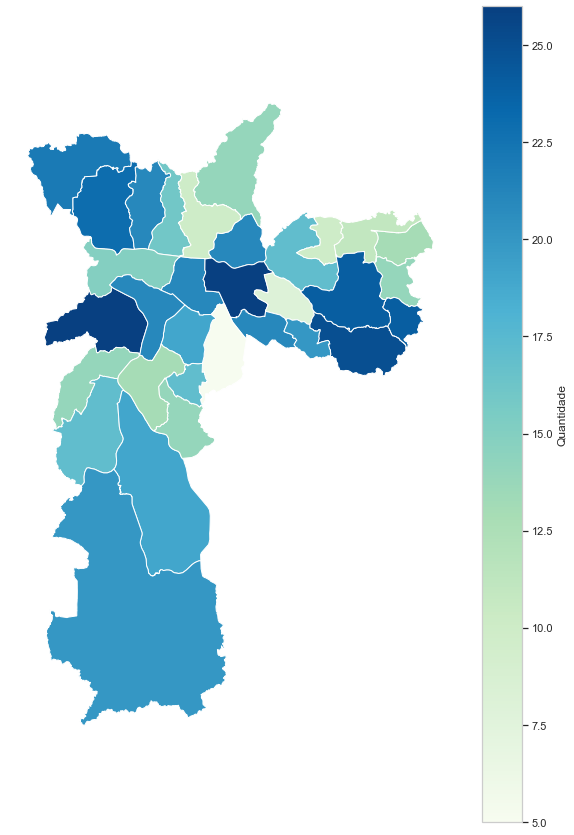

In [77]:
cmap_plot(subs, 'qtd_contrib_audi_por_subs', 'Quantidade de Falas nas Audiências Regionais')

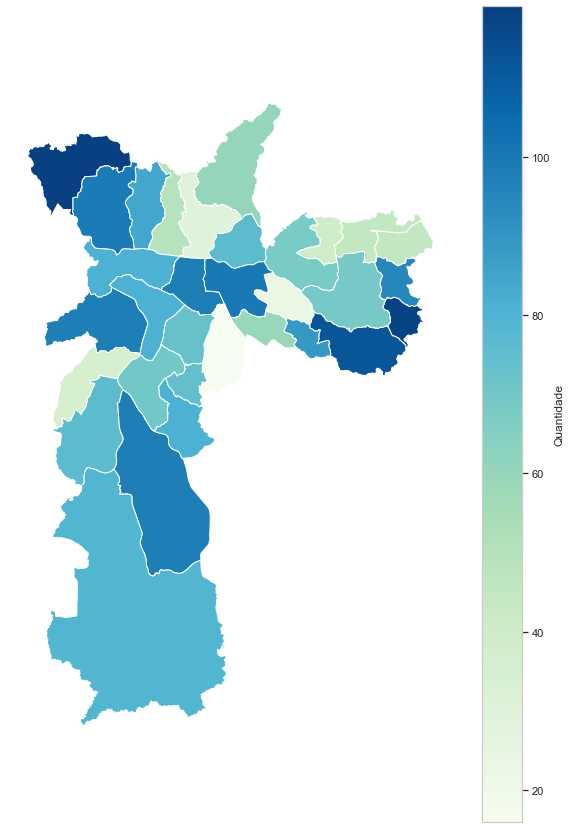

In [78]:
cmap_plot(subs, 'qtd_sugest_audi_por_subs', 'Quantidade de Sugestões nas Audiências Regionais')

In [79]:
tabela_mapas = subs.copy()

In [80]:
tabela_mapas = tabela_mapas[['sp_nome', 'qtd_por_subs_total', 'qtd_contrib_audi_por_subs', 'qtd_sugest_audi_por_subs']]

In [81]:
tabela_mapas = tabela_mapas.rename(
    {'sp_nome' : 'Subprefeitura',
    'qtd_por_subs_total' : 'Total de sugestões (P+, Audiências e PLOA)',
    'qtd_contrib_audi_por_subs' : 'Quantidade de falas Audiências Regionais',
    'qtd_sugest_audi_por_subs' : 'Quantidade de sugestões Audiencias Regionais'},
    axis = 1
)

In [82]:
tabela_mapas.to_excel('tabela_mapas.xlsx', index = False)

In [83]:
tabela_mapas

,Subprefeitura,"Total de sugestões (P+, Audiências e PLOA)",Quantidade de falas Audiências Regionais,Quantidade de sugestões Audiencias Regionais
0,PIRITUBA-JARAGUA,204,23,99
1,FREGUESIA-BRASILANDIA,154,21,84
2,CASA VERDE-CACHOEIRINHA,253,16,49
3,VILA MARIA-VILA GUILHERME,311,21,76
4,PENHA,181,17,68
5,ERMELINO MATARAZZO,126,10,40
6,ITAIM PAULISTA,237,13,45
7,GUAIANASES,149,14,95
8,LAPA,200,15,81
9,SE,217,21,98
